# Cyclistic Bike-Share Analysis Case Study

## Introduction

Cyclistic, a bike-share company based in Chicago, operates a fleet of more than 5,800 bicycles across over 600 docking stations. The company offers flexible pricing options—single-ride passes, full-day passes, and annual memberships—making it accessible to a wide range of riders.  
The Cyclistic executive team has identified **annual members** as a more profitable customer segment than **casual riders**. As such, the marketing team has set a strategic goal to **convert casual riders into annual members** to drive long-term growth and revenue stability.

### Project Goal
This analysis aims to answer the following key question:  
**“How do annual members and casual riders use Cyclistic bikes differently?”**

From these insights, we will design actionable marketing strategies to convert casual riders into members.

### Scope of Analysis
This notebook:
1. **Prepares and cleans the data** – Ensuring accurate and reliable analysis.
2. **Performs exploratory analysis** – Comparing riding patterns by membership type across:
   - Day and hour of the week
   - Ride durations and bike type preferences
   - Geographic trends and route popularity
3. **Visualizes key findings** – Presenting clear and interpretable charts and maps.
4. **Generates insights and actionable recommendations** – Focused on increasing membership conversions.

### Deliverables
- **Data-driven insights** about rider behavior.
- **Professional visualizations** illustrating usage patterns.
- **Top three actionable recommendations** for targeted marketing strategies.


In [17]:
!python --version
!pip install folium

Python 3.12.7


In [23]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import AntPath
import random

In [4]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "202407-divvy-tripdata.csv"))
print(df.head())

            ride_id  rideable_type               started_at  \
0  2658E319B13141F9  electric_bike  2024-07-11 08:15:14.784   
1  B2176315168A47CE  electric_bike  2024-07-11 15:45:07.851   
2  C2A9D33DF7EBB422  electric_bike  2024-07-11 08:24:48.192   
3  8BFEA406DF01D8AD  electric_bike  2024-07-11 08:46:06.864   
4  ECD3EF02E5EB73B6  electric_bike  2024-07-11 18:18:16.588   

                  ended_at start_station_name start_station_id  \
0  2024-07-11 08:17:56.335                NaN              NaN   
1  2024-07-11 16:06:04.243                NaN              NaN   
2  2024-07-11 08:28:05.237                NaN              NaN   
3  2024-07-11 09:14:11.664                NaN              NaN   
4  2024-07-11 18:30:20.288                NaN              NaN   

  end_station_name end_station_id  start_lat  start_lng  end_lat  end_lng  \
0              NaN            NaN      41.80     -87.59    41.79   -87.59   
1              NaN            NaN      41.79     -87.60    41.80   -87

After printing out the head of the dataframe of a sample csv, I noticed that that several of the columns were populated by null values. Hence, the next step was to identify if this was a systematic error or limited to specific columns.

In [5]:
data_path = os.path.join(os.getcwd(), "data")
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

nan_threshold = 0.1

problems_summary = []

all_data = []

for file in csv_files:
    file_path = os.path.join(data_path, file)
    try:
        # Read CSV file
        df = pd.read_csv(file_path)

        all_data.append(df)
        
        # Check missing values ratio per column
        missing_ratio = df.isna().sum() / len(df)
        problematic_columns = missing_ratio[missing_ratio > nan_threshold]
        
        if not problematic_columns.empty:
            for col, ratio in problematic_columns.items():
                problems_summary.append({
                    "file": file,
                    "column": col,
                    "missing_ratio": round(ratio * 100, 2)
                })
    except Exception as e:
        problems_summary.append({
            "file": file,
            "column": "READ_ERROR",
            "missing_ratio": str(e)
        })

# Convert summary to DataFrame
problems_df = pd.DataFrame(problems_summary)

df_concat = pd.concat(all_data, ignore_index=True)

In [6]:
print("Summary of files with missing values:")
print(problems_df.to_string(index=False))

# Remove columns with "start" or "end" in their name from the summary
filtered_problems_df = problems_df[~problems_df['column'].str.contains('start|end', case=False, na=False)]

print("Summary of files with missing values (excluding start/end columns):")
print(filtered_problems_df.to_string(index=False))


Summary of files with missing values:
                     file             column  missing_ratio
202407-divvy-tripdata.csv start_station_name          18.29
202407-divvy-tripdata.csv   start_station_id          18.29
202407-divvy-tripdata.csv   end_station_name          18.59
202407-divvy-tripdata.csv     end_station_id          18.59
202408-divvy-tripdata.csv start_station_name          18.61
202408-divvy-tripdata.csv   start_station_id          18.61
202408-divvy-tripdata.csv   end_station_name          18.82
202408-divvy-tripdata.csv     end_station_id          18.82
202409-divvy-tripdata.csv start_station_name          23.03
202409-divvy-tripdata.csv   start_station_id          23.03
202409-divvy-tripdata.csv   end_station_name          23.49
202409-divvy-tripdata.csv     end_station_id          23.49
202410-divvy-tripdata.csv start_station_name          17.39
202410-divvy-tripdata.csv   start_station_id          17.39
202410-divvy-tripdata.csv   end_station_name          17.77
20

It appears that all csvs have missing data in the columns start_station_name, start_station_id, end_station_name and end_station_id. As such, any analysis pertaining to these columns will need to undergo additional data cleaning.

In [7]:
print("Shape of dataframe pre-cleaning:", df_concat.shape)

nan_counts = df_concat.isna().sum()
nan_percent = (df_concat.isna().sum() / len(df_concat)) * 100
nan_summary = pd.DataFrame({
    "NaN Count": nan_counts,
    "NaN %": nan_percent.round(2)
}).sort_values(by="NaN %", ascending=False)

# Count duplicates
duplicate_count = df_concat.duplicated().sum()
duplicate_percent = (duplicate_count / len(df_concat)) * 100

print("\n=== Missing Values Summary ===")
print(nan_summary)
print("\n=== Duplicate Rows Summary ===")
print(f"Duplicate rows: {duplicate_count} ({duplicate_percent:.2f}%)")


Shape of dataframe pre-cleaning: (5597030, 13)

=== Missing Values Summary ===
                    NaN Count  NaN %
end_station_name      1119485  20.00
end_station_id        1119485  20.00
start_station_name    1088824  19.45
start_station_id      1088824  19.45
end_lat                  6030   0.11
end_lng                  6030   0.11
ride_id                     0   0.00
rideable_type               0   0.00
started_at                  0   0.00
ended_at                    0   0.00
start_lat                   0   0.00
start_lng                   0   0.00
member_casual               0   0.00

=== Duplicate Rows Summary ===
Duplicate rows: 0 (0.00%)


The concatenated df shows that the 4 problematic columns have up to 20% missing data. There are also some missing data for end_lat and end_lng amounting to 0.11% of all data. Interestingly, start_lat and start_lng have no missing data, which means that the rows with missing ending coordinates do have starting coordinates. However, as these rows still contain useful information regarding user timing, they will be kept until we perform location/coordinate analysis later.

There are no duplicate rows. So, no data cleaning is required on that end.

### Feature Generation

In [8]:
# Convert to datetime
df_concat['started_at'] = pd.to_datetime(df_concat['started_at'])
df_concat['ended_at'] = pd.to_datetime(df_concat['ended_at'])

# Calculate ride_length as timedelta
df_concat['ride_length'] = df_concat['ended_at'] - df_concat['started_at']

# Convert timedelta to seconds
df_concat['ride_length_seconds'] = df_concat['ride_length'].dt.total_seconds()

# Day of week: 1 = Sunday, 7 = Saturday (Excel-like)
df_concat['day_of_week'] = df_concat['started_at'].dt.weekday  # Monday=0, Sunday=6
df_concat['day_of_week'] = df_concat['day_of_week'].apply(lambda x: 1 if x == 6 else x + 2)

# Show rows with negative ride_length
negative_rides = df_concat[df_concat['ride_length_seconds'] < 0]
print("Rows with negative ride length:")
print(len(negative_rides), "rows found")
print(negative_rides)

df_concat = df_concat[df_concat['ride_length_seconds'] >= 0]
print("Minimum ride length:", df_concat['ride_length_seconds'].min())



Rows with negative ride length:
43 rows found
                  ride_id  rideable_type              started_at  \
2946648  A3C86101B94DCF83   classic_bike 2024-11-03 01:53:34.934   
2948636  9E3880C1B94EAB39  electric_bike 2024-11-03 01:48:07.988   
2951541  A21F9A727675300F  electric_bike 2024-11-03 01:53:22.726   
2958477  61C2AE038C0D67AB   classic_bike 2024-11-03 01:25:33.243   
2974249  E44DD2F8C07D6B2D  electric_bike 2024-11-03 01:49:17.648   
2976347  F147973D700AA375  electric_bike 2024-11-03 01:50:02.506   
2992602  F600DA96D6308ABF  electric_bike 2024-11-03 01:55:22.919   
2994429  CFED9E2BF0A7F676  electric_bike 2024-11-03 01:50:18.246   
3003009  BB4F8E728A4714E3   classic_bike 2024-11-03 01:55:10.885   
3007389  5DD72265826A6FC0   classic_bike 2024-11-03 01:53:34.793   
3028173  1ED3B2ACE0FE3C99  electric_bike 2024-11-03 01:59:24.648   
3036817  76C64FC8024DA2AC  electric_bike 2024-11-03 01:54:39.214   
3041697  CB6B83A69815601E   classic_bike 2024-11-03 01:25:14.083   
30

Based on the instructions given, 3 new features, "ride_length", "ride_length_seconds" and"day_of_week" were generated. A simple verification was conducted on the ride length data, and it was found that there were 43 rows with negative time. This is evidently not possible, but as there is insufficient information to correct the data, these rows will be removed.

Despite the removal of these "impossible" rows, there remain some "implausible" rows. For instance, one user managed to rent a bike for only 0.042 seconds, which is unlikely to be possible given human reaction time and hand speed. However, to quantify a non-zero filter is highly subjective and difficult, so these rows will be kept and the filter set at to remove negative values.

### Analysis

In [9]:
df_concat['date'] = df_concat['started_at'].dt.date
df_concat['month'] = df_concat['started_at'].dt.to_period('M')
df_concat['week'] = df_concat['started_at'].dt.to_period('W')
df_concat['day_name'] = df_concat['started_at'].dt.day_name()
df_concat['day_of_month'] = df_concat['started_at'].dt.day
df_concat['hour'] = df_concat['started_at'].dt.hour

def plot_trends(data, time_col, value_col, agg_func, title, ylabel):
    grouped_all = data.groupby(time_col).agg({value_col: agg_func}).reset_index()
    grouped_member = data[data['member_casual'] == 'member'].groupby(time_col).agg({value_col: agg_func}).reset_index()
    grouped_casual = data[data['member_casual'] == 'casual'].groupby(time_col).agg({value_col: agg_func}).reset_index()

    plt.figure(figsize=(12, 6))
    plt.plot(grouped_all[time_col].astype(str), grouped_all[value_col], label='All')
    plt.plot(grouped_member[time_col].astype(str), grouped_member[value_col], label='Member')
    plt.plot(grouped_casual[time_col].astype(str), grouped_casual[value_col], label='Casual')
    plt.title(title)
    plt.xlabel(time_col)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


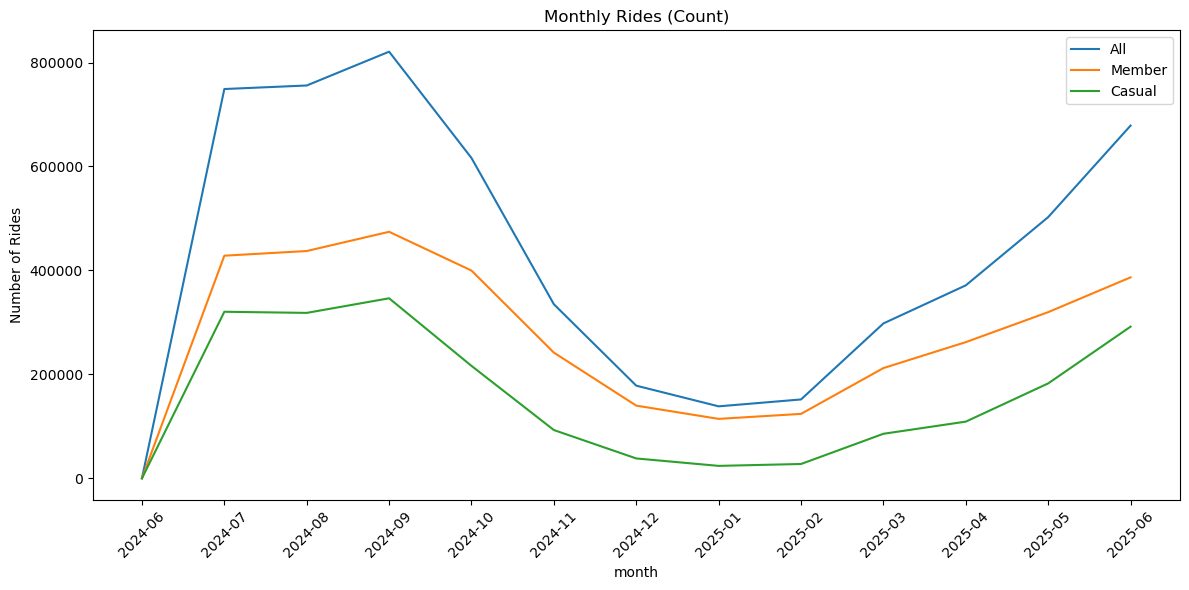

In [10]:
# --- Monthly (counts) ---
plot_trends(df_concat, 'month', 'ride_id', 'count', 'Monthly Rides (Count)', 'Number of Rides')

Based on these graphs, there are 2 main observations:

1. Members consistently accumulate more rides than casual riders. 

2. A seasonal trend where rides peak in summer-early autumn and bottoms out during winter

    Based on the the monthly ride count, we can observe a clear seasonal trend where number of rides rise from February to July, peaking in September, before decreasing and bottoming out in January.

    This can likely be explained by the individual's general aversion to ride out in the cold and in potentially dangerous road conditions.

    The month of June 2024 is an anomaly as they are residual data left over from July 2024's data.

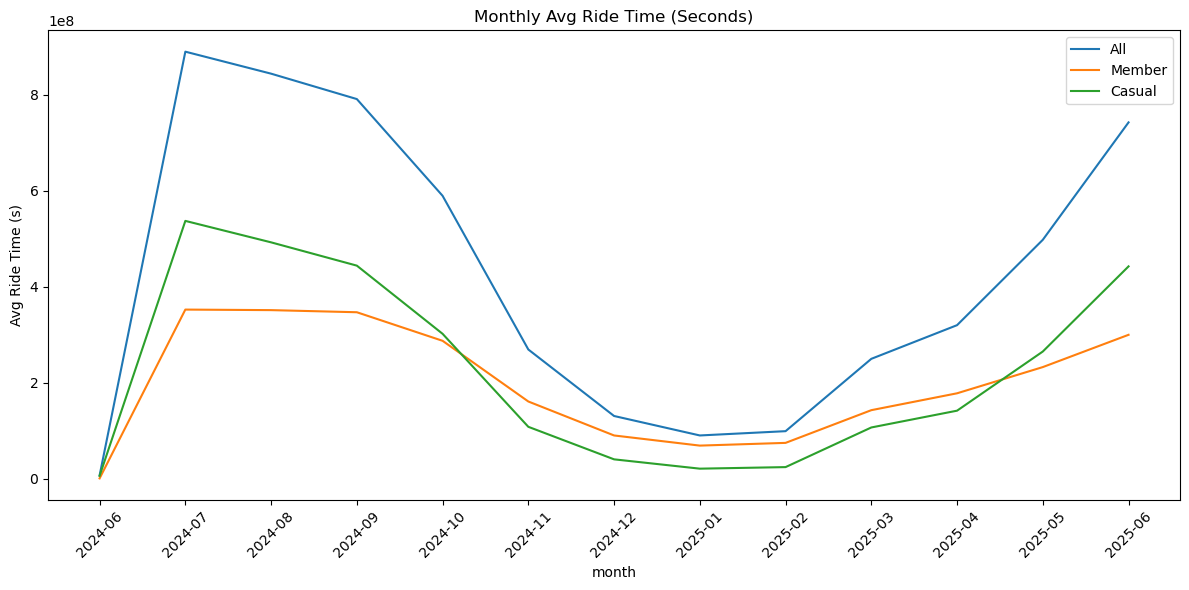

In [11]:
# --- Monthly (ride length) ---
plot_trends(df_concat, 'month', 'ride_length_seconds', 'sum', 'Monthly Avg Ride Time (Seconds)', 'Avg Ride Time (s)')

Interestingly, casual riders tend to spend more time per ride than annual members during the peak summer months. However, this pattern reverses in the colder winter months, from November through April. One possible explanation is that annual members are more likely to use bikes for all types of trips, whether short or long, while casual riders often rent bikes for special occasions or leisure activities, leading to longer average ride times in warmer weather. In contrast, during winter, casual riders may be less comfortable with challenging road conditions, resulting in a noticeable drop in their average ride time.

Further analysis into rider behaviour will be conducted later.

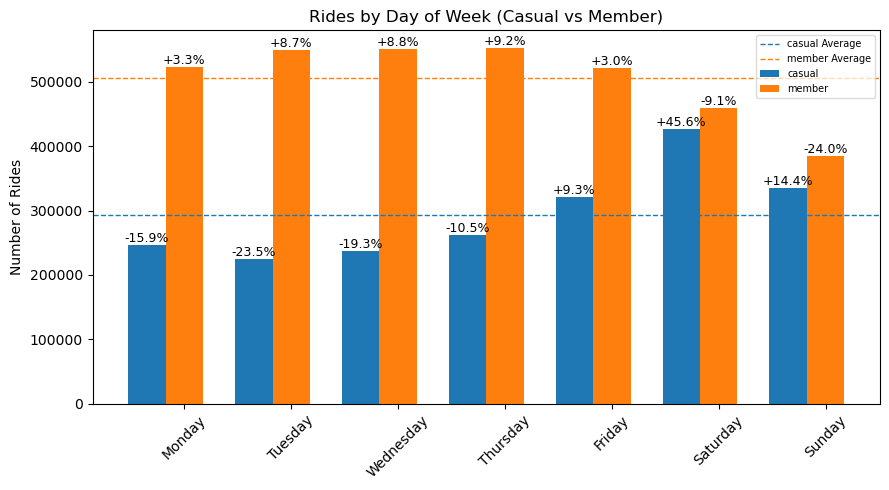

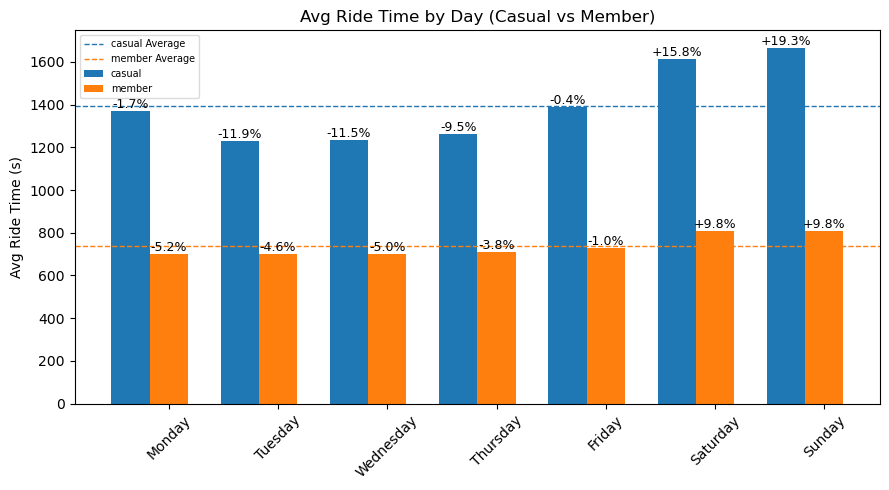

In [12]:
def plot_trends_split(df, group_col, split_col, value_col, agg_func, title, ylabel):
    # Aggregate by group and rider type
    if agg_func == 'count':
        agg_df = df.groupby([group_col, split_col])[value_col].count().reset_index(name='value')
    else:
        agg_df = df.groupby([group_col, split_col])[value_col].mean().reset_index(name='value')

    # Ensure day order
    if group_col == 'day_name':
        days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        agg_df[group_col] = pd.Categorical(agg_df[group_col], categories=days_order, ordered=True)
        agg_df = agg_df.sort_values([group_col, split_col])

    # Pivot for grouped bar chart
    pivot_df = agg_df.pivot(index=group_col, columns=split_col, values='value').fillna(0)
    groups = pivot_df.index
    rider_types = pivot_df.columns

    # Calculate averages for each rider type separately
    averages = pivot_df.mean()

    # Plot
    x = np.arange(len(groups))  # positions for groups
    width = 0.35                # width of each bar

    fig, ax = plt.subplots(figsize=(9, 5))
    colors = ['#1f77b4', '#ff7f0e']  # choose contrasting colors
    bars = []

    for i, rider_type in enumerate(rider_types):
        bar = ax.bar(x + (i - len(rider_types)/2)*width,
                     pivot_df[rider_type],
                     width,
                     label=rider_type,
                     color=colors[i % len(colors)])
        bars.append(bar)

        # Add % diff labels for each bar
        for rect, val in zip(bar, pivot_df[rider_type]):
            pct_diff = ((val - averages[rider_type]) / averages[rider_type]) * 100
            ax.text(rect.get_x() + rect.get_width()/2,
                    rect.get_height(),
                    f"{pct_diff:+.1f}%",
                    ha='center', va='bottom', fontsize=9)

        # Draw average line (no value in label)
        ax.axhline(averages[rider_type],
                   linestyle='--',
                   color=colors[i % len(colors)],
                   linewidth=1,
                   label=f"{rider_type} Average")

    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(groups, rotation=45)
    ax.set_title(title)
    ax.set_ylabel(ylabel)

    # Smaller legend
    legend = ax.legend(frameon=True, fontsize=7)
    legend.get_frame().set_alpha(0.7)

    plt.tight_layout()
    plt.show()

# --- Usage ---
plot_trends_split(df_concat, 'day_name', 'member_casual', 'ride_id', 'count',
                  'Rides by Day of Week (Casual vs Member)', 'Number of Rides')

plot_trends_split(df_concat, 'day_name', 'member_casual', 'ride_length_seconds', 'mean',
                  'Avg Ride Time by Day (Casual vs Member)', 'Avg Ride Time (s)')

**Analysis:**\
The data reveals clear differences in weekly ride patterns between casual and member riders. Casual riders exhibit higher usage on weekends and an uptick on Fridays, indicating that their trips are more leisure-oriented and tied to available free time. Member riders, on the other hand, show decreased usage on weekends and Fridays, with a significant drop on Sundays compared to Saturdays, suggesting that their primary use case is weekday commuting. Even so, member ridership remains relatively consistent across all days, hinting that some members also engage in leisure riding.

When looking at ride duration, the variation across days is smaller than the variation in ride counts. Both casual and member riders tend to have longer trips on weekends and Fridays, aligning with leisure-driven behavior. Casual riders consistently have higher average ride times than members, while member ride durations are more stable, likely reflecting frequent short-distance commuting trips.

**Insights:**

1. **Casual riders are leisure-focused** – They primarily use the service during free time, such as weekends and Fridays, and their trips are longer.
2. **Members are commute-driven** – Their usage peaks during the workweek and drops over the weekend, but their consistent weekday presence suggests regular commuting habits.
3. **Leisure influences both groups** – Both rider types extend their ride durations on weekends and Fridays, indicating increased recreational usage during non-working periods.


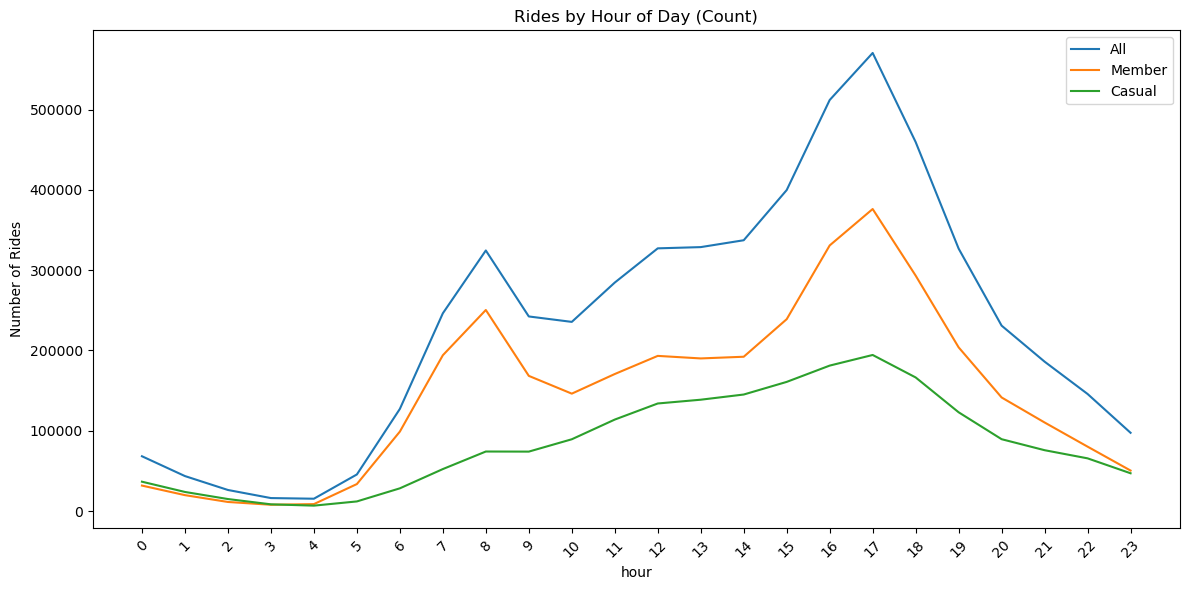

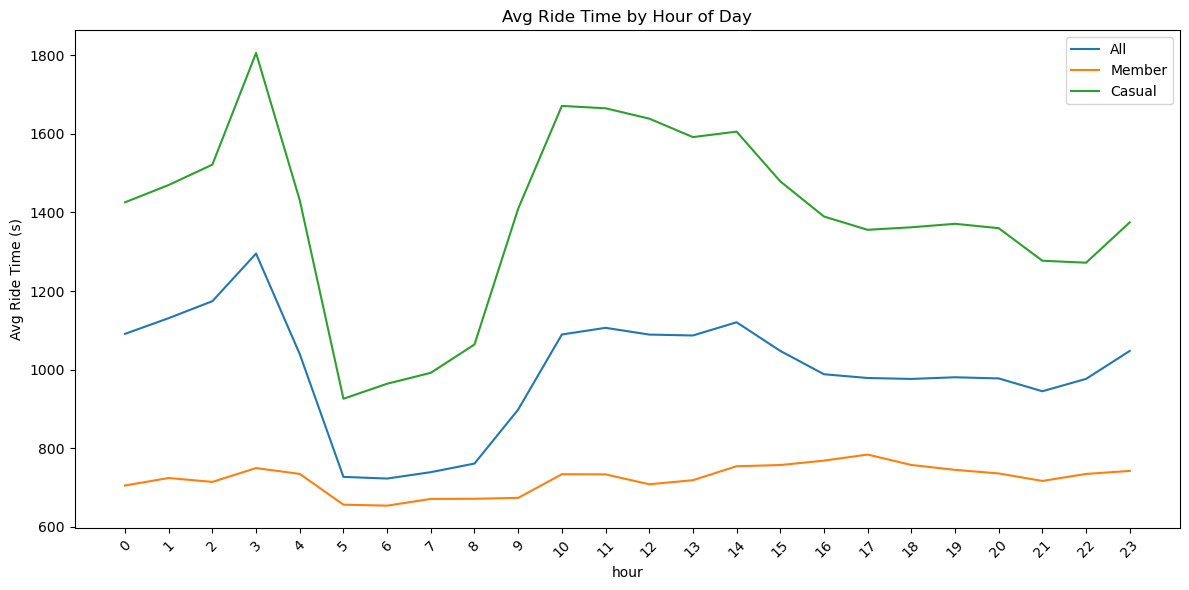

In [13]:
# --- Hour of day (count and ride length) ---
plot_trends(df_concat, 'hour', 'ride_id', 'count', 'Rides by Hour of Day (Count)', 'Number of Rides')
plot_trends(df_concat, 'hour', 'ride_length_seconds', 'mean', 'Avg Ride Time by Hour of Day', 'Avg Ride Time (s)')

**Analysis:**\
The hourly ride count chart shows distinct usage patterns between member and casual riders. Member rides have two prominent peaks during morning (around 8 AM) and evening (around 5 PM), aligning closely with typical commuting times, indicating that many members use the service for daily travel to and from work. In contrast, casual riders show a steady increase in rides throughout the day, with a single broad peak in the afternoon and early evening, reflecting leisure-oriented or discretionary trips rather than fixed commuting schedules.

For ride durations, casual riders consistently record longer average ride times than members, especially in the late morning and early afternoon, suggesting more leisure-oriented trips during those hours. A significant drop in ride durations is observed for trips starting between 5 AM and 8 AM, particularly among members, reflecting short, purpose-driven commuting rides during morning rush hours. Member ride times otherwise remain relatively stable throughout the day, consistent with frequent, shorter trips for daily travel rather than extended leisure rides.


**Insights:** 
1. Members primarily use the service as a commuting option, with predictable rush-hour peaks and shorter trip durations.
2. Casual riders, on the other hand, tend to ride during daylight and evening leisure hours, with longer trips, reinforcing the earlier finding that casual riders are more leisure-focused, while members use the service for daily travel needs.



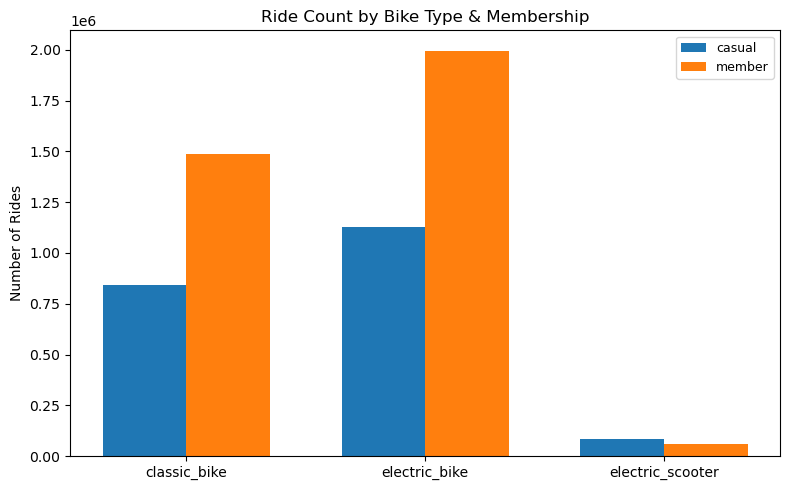

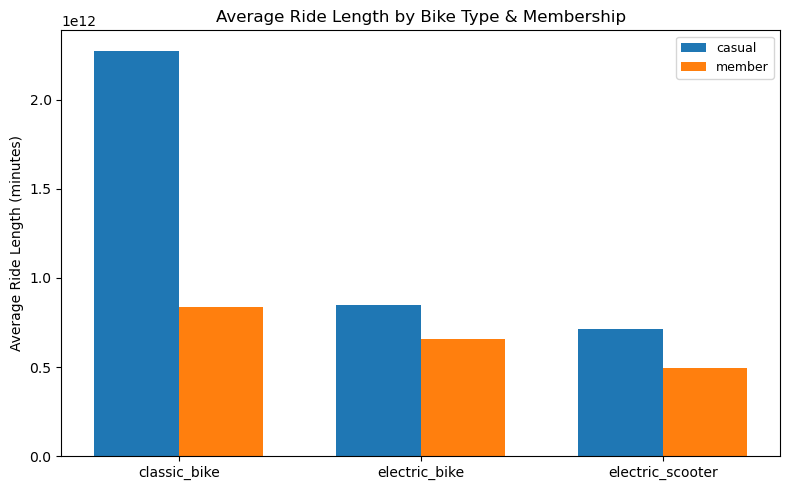

In [14]:
# --- Ride count by bike type and membership ---
ride_count = df_concat.groupby(['rideable_type', 'member_casual']).size().reset_index(name='ride_count')

# --- Average ride length by bike type and membership ---
avg_ride_length = df_concat.groupby(['rideable_type', 'member_casual'])['ride_length'].mean().reset_index(name='avg_ride_length')

# --- Merge summary ---
summary = ride_count.merge(avg_ride_length, on=['rideable_type', 'member_casual'])

# --- Visualization 1: Ride Count ---
fig, ax = plt.subplots(figsize=(8, 5))
rider_types = summary['member_casual'].unique()
x = np.arange(len(summary['rideable_type'].unique()))
width = 0.35

for i, rider_type in enumerate(rider_types):
    subset = summary[summary['member_casual'] == rider_type]
    ax.bar(x + i*width - width/2, subset['ride_count'], width, label=rider_type)

ax.set_xticks(x)
ax.set_xticklabels(summary['rideable_type'].unique())
ax.set_ylabel('Number of Rides')
ax.set_title('Ride Count by Bike Type & Membership')
ax.legend(frameon=True, fontsize=9)
plt.tight_layout()
plt.show()

# --- Visualization 2: Average Ride Length ---
fig, ax = plt.subplots(figsize=(8, 5))
for i, rider_type in enumerate(rider_types):
    subset = summary[summary['member_casual'] == rider_type]
    ax.bar(x + i*width - width/2, subset['avg_ride_length'], width, label=rider_type)


ax.set_xticks(x)
ax.set_xticklabels(summary['rideable_type'].unique())
ax.set_ylabel('Average Ride Length (minutes)')
ax.set_title('Average Ride Length by Bike Type & Membership')
ax.legend(frameon=True, fontsize=9)
plt.tight_layout()
plt.show()

**Analysis:**\
The charts reveal interesting trends regarding bike type and member type.
1. Both casual riders and members prefer the eletric bike to the classic bike. 
2. There are more casual riders of electric scooters than members who use the scooters.
3. The average ride length of the casual rider's on a classic bike is significantly longer than that of the members. This is in contrast to the average ride length on the electric bike, where the casual rider ride length is only slightly longer than that of the member. The average ride length on the electric scooter is comparable to that of the eletric bike. 

**Insights:**
1. Electric bikes are the dominant choice for both rider types, showing that the convenience and ease of electric assistance appeals broadly, not just to occasional riders.
2. Casual riders have a stronger presence in electric scooter usage compared to members, indicating scooters may be more attractive to occasional or tourist users rather than regular commuters. We do not know if the low ridership of scooters is due to low availability or general disinterest in electric scooters.
3. Classic bikes show the clearest behavioral divide: casual riders likely use them for much longer leisure-focused trips, while members use them for short, efficient travel.
4. Ride length differences shrink for electric bikes and scooters, suggesting these vehicles are used for similar types of trips by both casual and member riders, potentially due to speed and ease of use mitigating the ride duration gap. The average ride length could also be constrained by the battery life of the bike.

In [16]:
# --- Filter out rows with missing start or end station info ---
df_routes = df_concat.dropna(subset=['start_station_name', 'end_station_name'])

# --- Create route column for quick grouping ---
df_routes['route'] = df_routes['start_station_name'] + " → " + df_routes['end_station_name']

# --- Count routes (overall) ---
route_counts = df_routes.groupby('route').size().reset_index(name='ride_count')

# --- Count routes by membership ---
route_counts_membership = df_routes.groupby(['route', 'member_casual']).size().reset_index(name='ride_count')

# --- Sort to find top routes ---
top_routes = route_counts.sort_values('ride_count', ascending=False).head(20)
top_routes_by_membership = route_counts_membership.sort_values('ride_count', ascending=False).groupby('member_casual').head(20)

# --- Show top routes ---
print("Top 20 Routes (Overall):")
print(top_routes)

print("\nTop 20 Routes by Membership:")
print(top_routes_by_membership)

C:\Users\zhang\AppData\Local\Temp\ipykernel_109032\2099229322.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_routes['route'] = df_routes['start_station_name'] + " → " + df_routes['end_station_name']


Top 20 Routes (Overall):
                                                    route  ride_count
159844  Streeter Dr & Grand Ave → Streeter Dr & Grand Ave        8871
56155   DuSable Lake Shore Dr & Monroe St → DuSable La...        6954
56414   DuSable Lake Shore Dr & Monroe St → Streeter D...        5291
59692           Ellis Ave & 60th St → Ellis Ave & 55th St        5231
59404           Ellis Ave & 55th St → Ellis Ave & 60th St        4844
59764      Ellis Ave & 60th St → University Ave & 57th St        4765
109967      Michigan Ave & Oak St → Michigan Ave & Oak St        4762
20652          Calumet Ave & 33rd St → State St & 33rd St        4755
154892         State St & 33rd St → Calumet Ave & 33rd St        4665
162174     University Ave & 57th St → Ellis Ave & 60th St        4491
57566                     Dusable Harbor → Dusable Harbor        3315
112194                  Millennium Park → Millennium Park        3205
159561  Streeter Dr & Grand Ave → DuSable Lake Shore D...        

In [24]:
df_routes = df_concat.dropna(subset=['start_lat', 'start_lng', 'end_lat', 'end_lng'])

# --- Create route string ---
df_routes['route'] = df_routes['start_station_name'] + " → " + df_routes['end_station_name']

# --- Count routes ---
route_counts = (
    df_routes.groupby(['route', 'start_lat', 'start_lng', 'end_lat', 'end_lng'])
    .size()
    .reset_index(name='ride_count')
)

# --- Get top 20 routes ---
top_routes = route_counts.sort_values('ride_count', ascending=False).head(20).reset_index(drop=True)

# --- Map center (Chicago approximate) ---
m = folium.Map(location=[41.8781, -87.6298], zoom_start=12)

# --- Color palette ---
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightblue',
          'lightgreen', 'black', 'pink', 'cadetblue', 'darkblue', 'darkgreen']

# --- Add routes with labels ---
for idx, row in top_routes.iterrows():
    route_color = colors[idx % len(colors)]

    # Check if start and end are the same → draw a circle instead of a line
    if abs(row['start_lat'] - row['end_lat']) < 1e-5 and abs(row['start_lng'] - row['end_lng']) < 1e-5:
        folium.Circle(
            location=[row['start_lat'], row['start_lng']],
            radius=50,  # meters
            color=route_color,
            fill=True,
            fill_opacity=0.4,
            popup=f"#{idx+1} {row['route']} ({row['ride_count']} rides)"
        ).add_to(m)
        # Label at circle center with jitter
        jitter_lat = row['start_lat'] + random.uniform(-0.0002, 0.0002)
        jitter_lng = row['start_lng'] + random.uniform(-0.0002, 0.0002)
        folium.Marker(
            location=[jitter_lat, jitter_lng],
            icon=folium.DivIcon(
                html=f"""<div style="font-size: 12pt; color:{route_color}"><b>{idx+1}</b></div>"""
            )
        ).add_to(m)
    else:
        # Draw route line
        line_weight = max(3, row['ride_count'] / top_routes['ride_count'].max() * 10)
        AntPath(
            locations=[
                [row['start_lat'], row['start_lng']],
                [row['end_lat'], row['end_lng']]
            ],
            color=route_color,
            weight=line_weight,
            opacity=0.8
        ).add_to(m)
        # Midpoint for label with jitter
        mid_lat = (row['start_lat'] + row['end_lat']) / 2 + random.uniform(-0.0003, 0.0003)
        mid_lng = (row['start_lng'] + row['end_lng']) / 2 + random.uniform(-0.0003, 0.0003)
        folium.Marker(
            location=[mid_lat, mid_lng],
            icon=folium.DivIcon(
                html=f"""<div style="font-size: 12pt; color:{route_color}"><b>{idx+1}</b></div>"""
            ),
            popup=f"#{idx+1} {row['route']} ({row['ride_count']} rides)"
        ).add_to(m)

# --- Save map ---
m.save("top_routes_map.html")
print("Map saved as top_routes_map.html")

C:\Users\zhang\AppData\Local\Temp\ipykernel_109032\3562319703.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_routes['route'] = df_routes['start_station_name'] + " → " + df_routes['end_station_name']


Map saved as top_routes_map.html


Please view the html file separately. There are some interesting observation for general routes.

First, there are several clusters of biking behaviour. 

The first cluster is around Monroe harbour and Chicago's coast of Lake Michigan. There are several parks in this area, and several of the routes lead from one park to another, or start and end within the same park.

The second cluster is around the University of Chicago, with 4 routes leading within, in and out of the university to nearby Hyde Park.

There is also a bi-directional routes that showcases a different kind of trend. From Calumet Ave & 33rd St to State St & 33rd St and vice versa, this route connects the train station at Exelon Tube and a parking lot next to Pershing Elementary.

In [25]:
def plot_top_routes(data, filename, title="Top Routes"):
    # --- Count routes ---
    route_counts = (
        data.groupby(['route', 'start_lat', 'start_lng', 'end_lat', 'end_lng'])
        .size()
        .reset_index(name='ride_count')
    )

    # --- Get top 20 routes ---
    top_routes = route_counts.sort_values('ride_count', ascending=False).head(20).reset_index(drop=True)

    # --- Create map ---
    m = folium.Map(location=[41.8781, -87.6298], zoom_start=12, control_scale=True)

    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightblue',
              'lightgreen', 'black', 'pink', 'cadetblue', 'darkblue', 'darkgreen']

    for idx, row in top_routes.iterrows():
        route_color = colors[idx % len(colors)]

        # Check for round trips
        if abs(row['start_lat'] - row['end_lat']) < 1e-5 and abs(row['start_lng'] - row['end_lng']) < 1e-5:
            folium.Circle(
                location=[row['start_lat'], row['start_lng']],
                radius=50,  # meters
                color=route_color,
                fill=True,
                fill_opacity=0.4,
                popup=f"#{idx+1} {row['route']} ({row['ride_count']} rides)"
            ).add_to(m)

            # Label with jitter
            jitter_lat = row['start_lat'] + random.uniform(-0.0002, 0.0002)
            jitter_lng = row['start_lng'] + random.uniform(-0.0002, 0.0002)
            folium.Marker(
                location=[jitter_lat, jitter_lng],
                icon=folium.DivIcon(
                    html=f"""<div style="font-size: 12pt; color:{route_color}"><b>{idx+1}</b></div>"""
                )
            ).add_to(m)
        else:
            # Draw route
            line_weight = max(3, row['ride_count'] / top_routes['ride_count'].max() * 10)
            AntPath(
                locations=[
                    [row['start_lat'], row['start_lng']],
                    [row['end_lat'], row['end_lng']]
                ],
                color=route_color,
                weight=line_weight,
                opacity=0.8
            ).add_to(m)

            # Label midpoint with jitter
            mid_lat = (row['start_lat'] + row['end_lat']) / 2 + random.uniform(-0.0003, 0.0003)
            mid_lng = (row['start_lng'] + row['end_lng']) / 2 + random.uniform(-0.0003, 0.0003)
            folium.Marker(
                location=[mid_lat, mid_lng],
                icon=folium.DivIcon(
                    html=f"""<div style="font-size: 12pt; color:{route_color}"><b>{idx+1}</b></div>"""
                ),
                popup=f"#{idx+1} {row['route']} ({row['ride_count']} rides)"
            ).add_to(m)

    m.save(filename)
    print(f"Map saved as {filename}")

# --- Filter dataset for required maps ---
df_routes = df_concat.dropna(subset=['start_lat', 'start_lng', 'end_lat', 'end_lng'])
df_routes['route'] = df_routes['start_station_name'] + " → " + df_routes['end_station_name']

# 1) Classic bikes
classic_df = df_routes[df_routes['rideable_type'].str.contains("classic", case=False)]
plot_top_routes(classic_df, "top_routes_classic.html")

# 2) Electric bikes
electric_df = df_routes[df_routes['rideable_type'].str.contains("electric", case=False)]
plot_top_routes(electric_df, "top_routes_electric.html")

# 3) Casual riders
casual_df = df_routes[df_routes['member_casual'] == "casual"]
plot_top_routes(casual_df, "top_routes_casual.html")

# 4) Member riders
member_df = df_routes[df_routes['member_casual'] == "member"]
plot_top_routes(member_df, "top_routes_member.html")

C:\Users\zhang\AppData\Local\Temp\ipykernel_109032\765463276.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_routes['route'] = df_routes['start_station_name'] + " → " + df_routes['end_station_name']


Map saved as top_routes_classic.html
Map saved as top_routes_electric.html
Map saved as top_routes_casual.html
Map saved as top_routes_member.html


**Analysis:**\
The route maps by bike type and membership show clear differences in usage patterns.

Classic bike routes are very similar to the overall top routes, indicating that classic bikes are a well-rounded choice used widely across Chicago. The most popular routes are distributed throughout the city without strong geographic bias, suggesting that classic bikes are part of everyday mobility for a broad range of riders.

Electric bike routes show a more localized pattern, heavily concentrated around academic hubs such as the Illinois Institute of Technology (IIT), University of Illinois Chicago (UIC), and University of Chicago. This indicates high adoption of electric bikes in areas where speed and reduced effort are valued, likely due to hilly terrain or longer campus connections.

Casual rider routes are concentrated along the waterfront—parks, docks, and the harbor areas near Lake Michigan. These locations are popular tourist and leisure areas, suggesting casual riders use bikes primarily for recreational trips rather than functional commuting.

Member routes are clustered around the same university areas (IIT, UIC, University of Chicago), implying frequent use for student and staff commuting or inter-campus travel.

**Insights:**\
Classic bikes serve as the general-purpose mode for both casual and member riders, indicating that marketing or operational changes affecting classic bikes will have citywide impact.

Electric bikes are favored for university and academic hub travel, possibly for speed and convenience, which aligns with a younger, tech-friendly demographic. Targeting membership promotions at students and faculty near these institutions may increase conversion and retention.

Casual rider behavior confirms a leisure focus, with routes concentrated near Lake Michigan’s recreational zones. These riders are likely tourists or occasional users who rent bikes for scenic rides rather than transportation, suggesting that marketing to this segment should focus on leisure-oriented packages or promotions tied to tourist destinations.

Member routes indicate regular functional use, especially around university areas. This reinforces the pattern that members are commuting or making purposeful trips rather than sightseeing, supporting the value proposition of a membership for consistent, utility-driven riders.

# Final Conclusions and Recommendations

## Final Conclusion
The analysis of Cyclistic’s ride data reveals distinct behavioral differences between **casual riders** and **annual members**, influenced by both **purpose** and **bike type preference**:
- **Casual riders** primarily use the service for **leisure trips**, with activity peaking on weekends and concentrated along scenic areas near Lake Michigan. They also tend to take **longer trips**, especially on **classic bikes**, and have notable interest in **electric scooters and electric bikes** for occasional, flexible rides.
- **Annual members** use the service predominantly for **commuting and regular travel**, with weekday peaks during morning and evening hours. Their routes show heavy clustering around **universities and key transit areas**, with more consistent and shorter ride durations across all bike types.
- **Bike type usage** highlights the dominance of **electric bikes** (especially in university areas) and shows that **classic bikes remain the general-purpose option**. Casual riders disproportionately use routes in leisure areas, while members show dense networks around work and study hubs.

These insights emphasize the need for **targeted membership marketing strategies** rather than general outreach.

---

## How the Business Can Apply These Insights
1. **Targeted Marketing** – Campaigns should focus on converting casual riders into members by emphasizing the benefits of membership for leisure and recreational use, as well as highlighting cost savings for frequent rides.
2. **Service Planning** – Operational resources should prioritize electric bike availability around universities and high-demand commuter corridors, while ensuring adequate classic bike and docking capacity at leisure hotspots.
3. **Membership Growth** – Introduce membership offers tailored to university students and employees, as well as seasonal or tourist packages designed to attract casual riders interested in scenic routes and leisure travel.

---

## Next Steps for the Team and Stakeholders
1. **Develop and Launch Targeted Campaigns**  
   - University-focused campaigns (e.g., discounted student/staff memberships).  
   - Seasonal leisure campaigns (e.g., tourist packages during summer months).
2. **Optimize Fleet Allocation**  
   - Place more electric bikes in university and commuter-heavy areas.  
   - Maintain classic bike availability along Lake Michigan’s parks and harbors.
3. **Leverage Digital Media and Data Analytics**  
   - Use app notifications, social media, and geo-targeted ads to reach casual riders at leisure and tourist zones.  
   - Monitor route usage and customer response to campaigns to continuously refine strategy.

---

## Additional Data for Future Expansion
- **Demographics & Residency**: Understanding where casual riders live or work (while respecting privacy) would help tailor conversion strategies.
- **Tourism Data**: Identifying seasonal tourist patterns can better inform bike and dock placement.
- **Pricing Sensitivity**: Data on how pricing influences casual-to-member conversion would help optimize membership offers.

---

# Top Three Recommendations
1. **University Membership Campaigns**  
   Partner with Illinois Institute of Technology, University of Illinois Chicago, and University of Chicago to offer discounted memberships and promote electric bikes for commuting.

2. **Leisure-Focused Promotions**  
   Launch seasonal membership options and bundle offers targeting casual riders frequenting parks, harbors, and waterfront areas near Lake Michigan.

3. **Fleet and Infrastructure Optimization**  
   Ensure adequate electric bike availability around academic hubs and commuter corridors, while maintaining classic bike coverage for leisure areas, supported by dynamic rebalancing operations.
